In [43]:
import torch
import librosa
import os
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np

dataset_name = "HeartsOnFire-v.1.0.0"

df = pd.read_csv(os.path.join(dataset_name, "master.csv"))
train_df = pd.DataFrame()
valid_df = pd.DataFrame()

for idx, row in df.iterrows():
    onsets_path = row['onsets']
    onsets_df = pd.read_csv(onsets_path)
    train_onsets = onsets_df[onsets_df['split'] == 'training']
    valid_onsets = onsets_df[onsets_df['split'] == 'validation']
    
    # Append to respective dataframes
    train_df = pd.concat([train_df, train_onsets], ignore_index=True)
    valid_df = pd.concat([valid_df, valid_onsets], ignore_index=True)

train_df

,Unnamed: 0,onset_time,changed,kick,snare,hihat,tom,crash,ride,other,name,split,click,uncertain
0,0.0,8.161814,True,True,False,False,False,True,False,False,NanowaR of Steel - Disco Metal,training,NaN,NaN
1,2.0,8.974512,True,True,False,False,False,False,False,False,NanowaR of Steel - Disco Metal,training,NaN,NaN
2,3.0,9.369252,True,True,False,False,False,False,False,False,NanowaR of Steel - Disco Metal,training,NaN,NaN
3,4.0,9.589841,True,False,False,False,False,False,False,False,NanowaR of Steel - Disco Metal,training,NaN,NaN
4,5.0,9.763991,True,True,False,False,False,False,False,False,NanowaR of Steel - Disco Metal,training,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3327,853.0,208.224943,True,False,False,False,False,False,False,False,Toehider - To Hide Her,training,NaN,NaN
3328,855.0,208.642902,True,False,False,False,True,False,False,False,Toehider - To Hide Her,training,NaN,NaN
3329,858.0,209.142132,True,False,False,False,True,False,False,False,Toehider - To Hide Her,training,NaN,NaN
3330,860.0,209.304671,True,False,False,False,True,False,False,False,Toehider - To Hide Her,training,NaN,NaN


In [44]:
counts = train_df.select_dtypes(include=bool).sum(axis=0)
counts

changed    2514
kick       1542
snare      1062
hihat       934
tom         266
crash       323
ride        115
other       138
dtype: int64

In [45]:
from torch_audiomentations import Compose, PitchShift, Gain, Shift, AddColoredNoise
class MyGPULambdaTransform:
    def __init__(self):
        pass
    
    def __call__(self, x):
        # Perform your GPU operations here using PyTorch functions
        # For example:    
        gaussian_noise = AddColoredNoise(
            min_snr_in_db=3,
            max_snr_in_db=30,
            sample_rate=44100,
            p=0.5,
            output_type='tensor'
        ).to("cuda")
        time_shift = Shift(
            min_shift=-0.25,
            max_shift=0.25,
            rollover=False,
            p=0.5,
            sample_rate=44100,
            output_type='tensor'
        ).to("cuda")
        pitch_shift = PitchShift(
            min_transpose_semitones=-1,
            max_transpose_semitones=1,
            p=0.25,
            sample_rate=44100,
            output_type='tensor'
        ).to("cuda")
        gain = Gain(p=0.5, output_type='tensor').to("cuda")
        augmenter = Compose([time_shift, gain, pitch_shift, gaussian_noise], output_type='tensor').to("cuda")

        return augmenter(samples=x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)

In [47]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms

drum_labels = ['kick', 'snare', 'hihat', 'tom', 'crash', 'ride']
# Define the dataset class
class DrumDataset(Dataset):
    def __init__(self, df, master_csv_path, transform, window_size=8192):
        self.df = df
        self.master_df = pd.read_csv(master_csv_path)
        self.window_size = window_size
        self.transform = transform
        self.audio_cache = {}

        for i, row in self.master_df.iterrows():
            audio_path = row['drums']
            audio, sr = torchaudio.load(audio_path, format="mp3")
            if audio.shape[0] == 2:
                audio = torch.mean(audio, dim=0, keepdim=True)
            self.audio_cache[row['name']] = (audio, sr)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load the onset time, label, and track name for the given index
        row = self.df.iloc[idx]
        onset_time = row['onset_time']
        labels = row[drum_labels].astype(int).values.flatten()
        labels = torch.tensor(labels).float()
        track_name = row['name']
        #print(track_name, onset_time)

        audio = self.audio_cache[track_name][0]
        sr = self.audio_cache[track_name][1]

        onset_window = audio[:, int(onset_time*sr)-self.window_size//2:int(onset_time*sr)+self.window_size//2]
        spec = self.transform(onset_window[0])
        return spec, labels

train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.to("cuda")),
    MyGPULambdaTransform(),
    transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                n_fft=1024,
                hop_length=64,
                n_mels=128
            ).to("cuda")(x),
    torchaudio.transforms.MFCC(
                n_mfcc=128,
                melkwargs={'n_fft': 1024, 'hop_length': 64, 'n_mels': 128}).to("cuda")(x)
            ], dim=0).to("cuda")),
    transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB().to("cuda")(x[0]),
            x[0],
            x[1]
        ], dim=0).to("cuda")),
    transforms.Lambda(lambda x: x.to("cpu"))
])

valid_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.to("cuda")),
    transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                n_fft=2048,
                hop_length=64,
                n_mels=128
            ).to("cuda")(x),
    torchaudio.transforms.MFCC(
                n_mfcc=128,
                melkwargs={'n_fft': 2048, 'hop_length': 64, 'n_mels': 128}).to("cuda")(x)
            ], dim=0).to("cuda")),
    transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB().to("cuda")(x[0]),
            x[0],
            x[1]
        ], dim=0).to("cuda")),
    transforms.Lambda(lambda x: x.to("cpu"))
])

valid_dataset = DrumDataset(valid_df, "HeartsOnFire-v.1.0.0/master.csv", valid_transform)
train_dataset = DrumDataset(train_df, "HeartsOnFire-v.1.0.0/master.csv", train_transform)

3142 tensor([0., 0., 0., 0., 0., 1.])


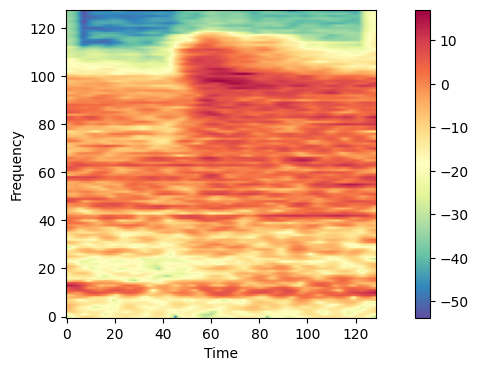

In [55]:
rand = random.randint(1, len(train_df))
a, x = train_dataset.__getitem__(rand)
specgram = a[0].detach().squeeze(0).numpy()
print(rand, x)

# Display the spectrogram using matplotlib
plt.figure(figsize=(10, 4))
plt.imshow(specgram, cmap='Spectral_r', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()
#477 

In [56]:
# Define the neural network architecture
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import torch.nn as nn
from tqdm import tqdm

n_epochs = 20
learning_rate = 0.001
batch_size = 8

class DrumCNN(nn.Module):
    def __init__(self):
        super(DrumCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(256, len(drum_labels))
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Convolutional Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x

device = torch.device('cuda')

In [279]:
def accuracy(outputs, labels, threshold=0.5):
    with torch.no_grad():
        preds = (outputs > threshold).float()
        correct = (preds == labels).sum(dim=1).eq(labels.shape[1]).sum().item()
        total = labels.shape[0]
        return 100 * correct / total

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Initialize the neural network and optimizer
device = torch.device('cuda')
model = DrumCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(n_epochs):
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0

    model.train()
    for i, (inputs, labels) in enumerate(tqdm(train_loader, total=len(train_loader), unit='batch', desc=f"Epoch {epoch+1}/{n_epochs} Training")):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_acc += accuracy(outputs, labels) * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    # Evaluate the model on the validation set
    true_labels = []
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(valid_loader, total=len(valid_loader), unit='batch', desc=f"Epoch {epoch+1}/{n_epochs} Validation")):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            valid_acc += accuracy(outputs, labels) * inputs.size(0)
            true_labels.extend(labels.cpu().numpy().tolist())
            predicted_labels.extend((outputs.cpu() > 0.5).float().numpy().tolist())
        valid_loss /= len(valid_loader.dataset)
        valid_acc /= len(valid_loader.dataset)

        cm = multilabel_confusion_matrix(true_labels, predicted_labels)
        f, axes = plt.subplots(1, 6, figsize=(25, 6))
        axes = axes.ravel()
        for i in range(len(drum_labels)):
            disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
            disp.plot(ax=axes[i], values_format='.4g')
            disp.ax_.set_title(drum_labels[i])
            disp.im_.colorbar.remove()

        plt.subplots_adjust(wspace=0.10, hspace=0.1)
        f.colorbar(disp.im_, ax=axes)
        plt.savefig(f'cm_e{epoch+1}.png')
        plt.close()
    
    # Update the learning rate based on the validation loss
    scheduler.step(valid_loss)
    
    # Print the training and validation loss and accuracy
    tqdm.write(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')

Epoch 1/10 Training:  13%|█▎        | 19/148 [00:14<01:39,  1.30batch/s]


KeyboardInterrupt: 

In [243]:
torch.save(model.state_dict(), f'{dataset_name}_{valid_acc:.2f}.pth')

In [17]:
name = "Toehider - To Hide Her"
label_onset_path = f"HeartsOnFire-v.1.0.0/{name}/onsets.csv"
label_df = pd.read_csv(label_onset_path)
label_df["name"] = name
label_df

,onset_time,kick,snare,hihat,tom,crash,ride,other,name
0,0.719819,False,False,False,False,False,False,False,Toehider - To Hide Her
1,1.068118,False,False,False,False,False,False,False,Toehider - To Hide Her
2,1.393197,False,False,False,False,False,False,False,Toehider - To Hide Her
3,1.729887,False,False,False,False,False,False,False,Toehider - To Hide Her
4,2.054966,False,False,False,False,False,False,False,Toehider - To Hide Her
...,...,...,...,...,...,...,...,...,...
1316,339.382857,False,False,False,False,False,False,False,Toehider - To Hide Her
1317,339.557007,False,False,False,False,False,False,False,Toehider - To Hide Her
1318,339.719546,False,False,False,False,False,False,False,Toehider - To Hide Her
1319,340.056236,False,False,False,False,False,False,False,Toehider - To Hide Her


In [18]:
checkpoint = torch.load('HeartsOnFire-v.1.0.0_54.702.pth')
model = DrumCNN().to(device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [19]:
labeling_dataset = DrumDataset(label_df, "HeartsOnFire-v.1.0.0/master.csv", valid_transform)
labeling_loader = DataLoader(labeling_dataset, batch_size=32, shuffle=False)

model.eval()
predicted_labels=[]
with torch.no_grad():
    for i, (inputs, labels) in enumerate(tqdm(labeling_loader, total=len(labeling_loader), unit='batch', desc=f"Labeling")):
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted_labels.extend((outputs>0.5).cpu().numpy().tolist())

Labeling: 100%|██████████| 42/42 [00:13<00:00,  3.10batch/s]


In [20]:
label_df[['kick', 'snare', 'hihat', 'tom', 'crash', 'ride']] = predicted_labels
label_df

,onset_time,kick,snare,hihat,tom,crash,ride,other,name
0,0.719819,True,False,False,False,False,False,False,Toehider - To Hide Her
1,1.068118,False,False,True,False,False,False,False,Toehider - To Hide Her
2,1.393197,True,False,False,False,False,False,False,Toehider - To Hide Her
3,1.729887,False,False,True,False,False,False,False,Toehider - To Hide Her
4,2.054966,True,False,False,False,False,False,False,Toehider - To Hide Her
...,...,...,...,...,...,...,...,...,...
1316,339.382857,True,False,False,False,False,False,False,Toehider - To Hide Her
1317,339.557007,True,False,False,False,False,False,False,Toehider - To Hide Her
1318,339.719546,False,False,True,False,False,False,False,Toehider - To Hide Her
1319,340.056236,False,False,True,False,False,False,False,Toehider - To Hide Her


In [21]:
label_df.to_csv(label_onset_path)